In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"üì¶ Using device: {DEVICE}")


üì¶ Using device: cpu


In [3]:
class EEGNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(1, 64), padding="same", bias=False),
            nn.BatchNorm2d(8)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(64, 1), groups=8, bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(1, 16), padding="same", bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )

        self.classify = None  # D√©finie dynamiquement plus tard
        self.n_classes = n_classes

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)

        if self.classify is None:
            self.classify = nn.Linear(x.shape[1], self.n_classes).to(x.device)

        return self.classify(x)


In [4]:
# Simulation de chargement de donn√©es
X = np.load("X_windows.npy")  # (n_samples, n_channels, n_times)
y = np.load("y_windows.npy")  # (n_samples,)

print("‚úÖ Donn√©es charg√©es :")
print("Shape X :", X.shape)
print("Classes :", Counter(y))


‚úÖ Donn√©es charg√©es :
Shape X : (90, 64, 641)
Classes : Counter({np.int64(2): 45, np.int64(4): 24, np.int64(3): 21})


In [5]:
X = torch.tensor(X).float()
y = torch.tensor(y).long()
X = X.unsqueeze(1)  # Ajouter la dimension canal 1 (batch, 1, ch, time)


In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"===== Fold {fold+1} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    # Entra√Ænement
    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    # √âvaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


===== Fold 1 =====


C:\Users\Antoi\miniconda3\envs\eeg-bci-env\lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


IndexError: Target 2 is out of bounds.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")

# === EEGNet modifi√© pour accepter n_classes dynamiquement ===
class EEGNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding='same', bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(64, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        # Calcul automatique de la taille d‚Äôentr√©e pour la couche lin√©aire
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 64, 641).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)  # Ajoute canal pour Conv2D
        elif x.ndim == 5:
            x = x.squeeze(1)  # Corrige input d√©j√† trop dimensionn√©
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)


# === Entra√Ænement avec validation crois√©e ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

‚úÖ Labels remapp√©s : {2: 0, 3: 1, 4: 2}
üéØ Nombre de classes d√©tect√©es : 3
üìä Distribution des classes : Counter({0: 45, 2: 24, 1: 21})

===== Fold 1 =====
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 3.4051 ‚Äî Acc: 51.39%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 2.0680 ‚Äî Acc: 76.39%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 1.7291 ‚Äî Acc: 77.78%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 1.2698 ‚Äî Acc: 86.11%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 1.0951 ‚Äî Acc: 91.67%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 0.8360 ‚Äî Acc: 95.83%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 0.6465 ‚Äî Acc: 94.44%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 0.5347 ‚Äî Acc: 98.61%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 0.4089 ‚Äî Acc: 98.61%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 0.3918 ‚Äî Acc: 98.61%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          

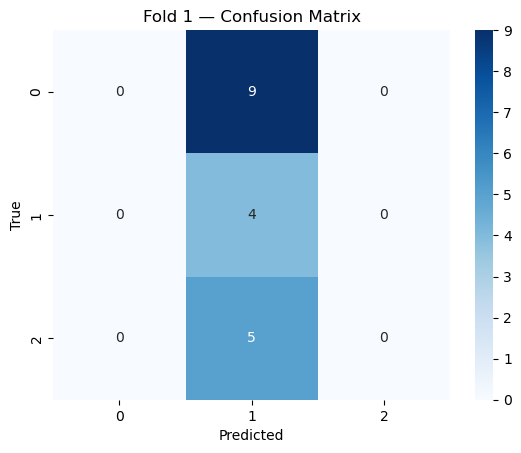


===== Fold 2 =====
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 3.2516 ‚Äî Acc: 37.50%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 2.1253 ‚Äî Acc: 75.00%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 1.8148 ‚Äî Acc: 81.94%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 1.5564 ‚Äî Acc: 83.33%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 1.0663 ‚Äî Acc: 95.83%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 1.0429 ‚Äî Acc: 91.67%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 0.8086 ‚Äî Acc: 98.61%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 0.6178 ‚Äî Acc: 98.61%
üß† Fold 2 ‚Äî Epoch 09 ‚Äî Loss: 0.6763 ‚Äî Acc: 98.61%
üß† Fold 2 ‚Äî Epoch 10 ‚Äî Loss: 0.4128 ‚Äî Acc: 100.00%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



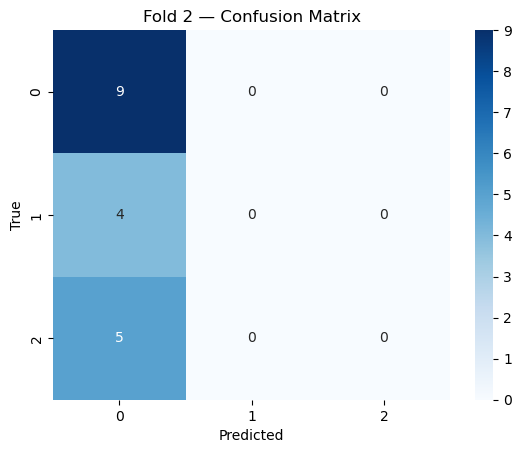


===== Fold 3 =====
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 3.4040 ‚Äî Acc: 33.33%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 2.3637 ‚Äî Acc: 70.83%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 1.6429 ‚Äî Acc: 87.50%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 1.7538 ‚Äî Acc: 86.11%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 1.0073 ‚Äî Acc: 93.06%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 0.9082 ‚Äî Acc: 93.06%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 0.6429 ‚Äî Acc: 100.00%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 0.6241 ‚Äî Acc: 100.00%
üß† Fold 3 ‚Äî Epoch 09 ‚Äî Loss: 0.4730 ‚Äî Acc: 100.00%
üß† Fold 3 ‚Äî Epoch 10 ‚Äî Loss: 0.3480 ‚Äî Acc: 98.61%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.000     0.000     0.000         4
           2      0.278     1.000     0.435         5

    accuracy                          0.278        18
   macro avg      0.093     0.333     0.145        18
weighted avg      0.077     0.278     0.121        18



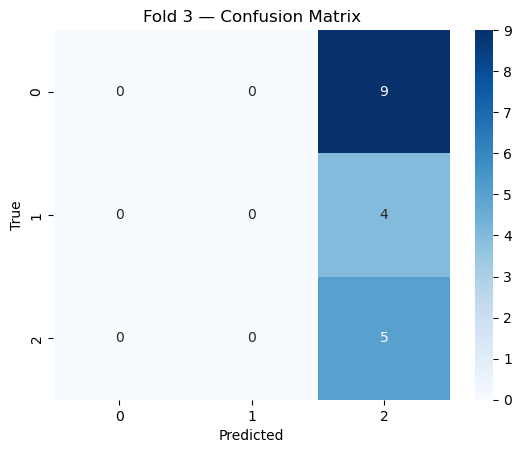


===== Fold 4 =====
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 3.4458 ‚Äî Acc: 41.67%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 2.1141 ‚Äî Acc: 80.56%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 1.7914 ‚Äî Acc: 83.33%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 1.2669 ‚Äî Acc: 88.89%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 1.0690 ‚Äî Acc: 93.06%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 0.8793 ‚Äî Acc: 97.22%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 0.6044 ‚Äî Acc: 95.83%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 0.5610 ‚Äî Acc: 97.22%
üß† Fold 4 ‚Äî Epoch 09 ‚Äî Loss: 0.4010 ‚Äî Acc: 100.00%
üß† Fold 4 ‚Äî Epoch 10 ‚Äî Loss: 0.3791 ‚Äî Acc: 100.00%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



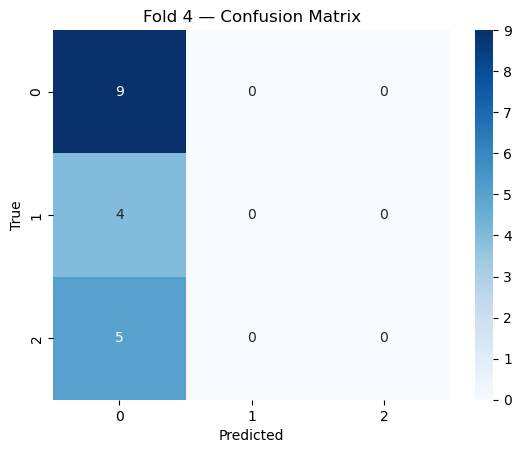


===== Fold 5 =====
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 3.4201 ‚Äî Acc: 36.11%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 2.2234 ‚Äî Acc: 80.56%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 1.8907 ‚Äî Acc: 87.50%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 1.4309 ‚Äî Acc: 88.89%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 1.0886 ‚Äî Acc: 95.83%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 0.9461 ‚Äî Acc: 97.22%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 0.7302 ‚Äî Acc: 97.22%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 0.5051 ‚Äî Acc: 98.61%
üß† Fold 5 ‚Äî Epoch 09 ‚Äî Loss: 0.4517 ‚Äî Acc: 100.00%
üß† Fold 5 ‚Äî Epoch 10 ‚Äî Loss: 0.4140 ‚Äî Acc: 98.61%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.278     1.000     0.435         5
           2      0.000     0.000     0.000         4

    accuracy                          0.278        18
   macro avg      0.093     0.333     0.145        18
weighted avg      0.077     0.278     0.121        18



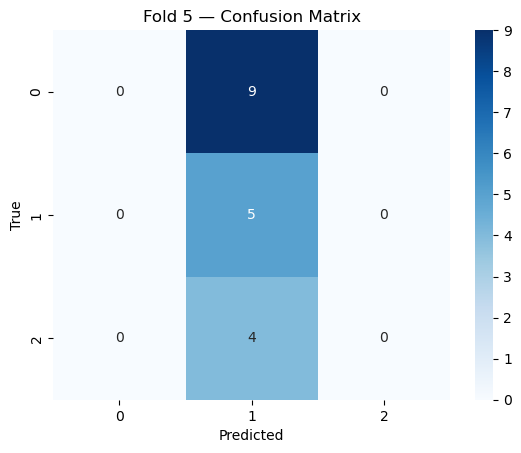

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === EEGNet modifi√© pour s‚Äôadapter automatiquement √† l‚Äôentr√©e ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.input_shape = input_shape  # (n_channels, n_times)
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)


# === Pond√©ration des classes pour CrossEntropyLoss ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# === Cross-validation stratifi√©e ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === Fonctions d'augmentation des donn√©es EEG ===
def augment_data(X, y, target_count_per_class):
    X_aug, y_aug = [], []
    for cls in torch.unique(y):
        cls_indices = (y == cls).nonzero(as_tuple=True)[0]
        X_cls = X[cls_indices]
        y_cls = y[cls_indices]
        needed = target_count_per_class - len(X_cls)

        if needed <= 0:
            X_aug.append(X_cls)
            y_aug.append(y_cls)
        else:
            for i in range(needed):
                idx = torch.randint(0, len(X_cls), (1,)).item()
                x_orig = X_cls[idx]
                x_noisy = x_orig + 0.01 * torch.randn_like(x_orig)  # Bruit gaussien
                shift = torch.randint(0, 10, (1,)).item()
                x_shifted = torch.roll(x_noisy, shifts=shift, dims=-1)  # D√©calage temporel
                x_scaled = x_shifted * (0.9 + 0.2 * torch.rand(1).item())  # Scaling
                X_aug.append(x_scaled.unsqueeze(0))
                y_aug.append(torch.tensor([cls]))

    return torch.cat(X_aug, dim=0), torch.cat(y_aug, dim=0)

# === EEGNet modifi√© pour s‚Äôadapter automatiquement √† l‚Äôentr√©e ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Cross-validation stratifi√©e avec augmentation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Augmentation
    max_class_size = max(Counter(y_train.tolist()).values())
    X_train, y_train = augment_data(X_train, y_train, target_count_per_class=max_class_size)
    print(f"üîÅ Donn√©es apr√®s augmentation : {Counter(y_train.tolist())}")

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üßê Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === Fonctions d'augmentation ===
def add_gaussian_noise(x, std=0.05):
    return x + torch.randn_like(x) * std

def time_shift(x, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, min_scale=0.9, max_scale=1.1):
    scale = torch.empty(1).uniform_(min_scale, max_scale).item()
    return x * scale

def random_warp(x, max_warp=0.1):
    t = torch.linspace(0, 1, x.shape[-1])
    warp = torch.sin(2 * np.pi * t * np.random.uniform(1, 3)) * max_warp
    return x + warp.to(x.device)

def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    if seg_len == 0:
        return x
    indices = np.arange(segs)
    np.random.shuffle(indices)
    segments = [x[..., i*seg_len:(i+1)*seg_len] for i in indices]
    return torch.cat(segments, dim=-1)

def augment_batch(x):
    augmented = []
    original_len = x.shape[-1]
    for i in range(x.shape[0]):
        xi = x[i]
        if torch.rand(1).item() < 0.5:
            xi = add_gaussian_noise(xi)
        if torch.rand(1).item() < 0.5:
            xi = time_shift(xi)
        if torch.rand(1).item() < 0.5:
            xi = scale_amplitude(xi)
        if torch.rand(1).item() < 0.5:
            xi = random_warp(xi)
        if torch.rand(1).item() < 0.5:
            xi = segment_permutation(xi)
        xi = xi[..., :original_len]  # Troncature
        xi = nn.functional.pad(xi, (0, original_len - xi.shape[-1]))  # Padding si besoin
        augmented.append(xi)
    return torch.stack(augmented)

# === Nettoyage des labels ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)
print(f"\n‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === EEGNet dynamiquement adaptable ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]
        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Poids de classe ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# === Cross-validation stratifi√©e ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = augment_batch(xb)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === Fonctions d'augmentation de donn√©es EEG ===
def add_gaussian_noise(x, mean=0.0, std=0.05):
    return x + torch.randn_like(x) * std

def time_shift(x, shift_max=0.1):
    shift = int(x.shape[-1] * shift_max * torch.rand(1).item())
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, scale_range=(0.9, 1.1)):
    scale = torch.empty(1).uniform_(*scale_range).item()
    return x * scale

def random_warp(x, max_jitter=3):
    jitter = torch.randint(-max_jitter, max_jitter + 1, (x.shape[-1],))
    jitter = jitter.float().cumsum(dim=0)
    jitter = jitter - jitter.min()
    jitter = jitter / jitter.max() * (x.shape[-1] - 1)
    jitter = jitter.long().clamp(0, x.shape[-1] - 1)
    return x[..., jitter]

def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    if seg_len == 0:
        return x
    indices = np.arange(segs)
    np.random.shuffle(indices)
    segments = []
    for i in indices:
        start = i * seg_len
        end = start + seg_len
        segments.append(x[..., start:end])
    return torch.cat(segments, dim=-1)

def augment_batch(x):
    augmented = []
    for xi in x:
        if torch.rand(1).item() < 0.5:
            xi = add_gaussian_noise(xi)
        if torch.rand(1).item() < 0.5:
            xi = time_shift(xi)
        if torch.rand(1).item() < 0.5:
            xi = scale_amplitude(xi)
        if torch.rand(1).item() < 0.5:
            xi = random_warp(xi)
        if torch.rand(1).item() < 0.5:
            xi = segment_permutation(xi)
        # S'assurer que toutes les formes soient homog√®nes
        if xi.shape[-1] != x.shape[-1]:
            pad = x.shape[-1] - xi.shape[-1]
            if pad > 0:
                xi = torch.nn.functional.pad(xi, (0, pad))
            else:
                xi = xi[..., :x.shape[-1]]
        augmented.append(xi)
    return torch.stack(augmented)

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === EEGNet modifi√© pour s‚Äôadapter automatiquement √† l‚Äôentr√©e ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.input_shape = input_shape  # (n_channels, n_times)
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Pond√©ration des classes pour CrossEntropyLoss ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# === Cross-validation stratifi√©e ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = augment_batch(xb)  # Ajout d'augmentations
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üßú‚Äç‚ôÇÔ∏è Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


‚úÖ Labels remapp√©s : {0: 0, 1: 1, 2: 2}
üéØ Nombre de classes d√©tect√©es : 3
üìä Distribution des classes : Counter({0: 45, 2: 24, 1: 21})

===== Fold 1 =====
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 3.3985 ‚Äî Acc: 30.56%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 3.3964 ‚Äî Acc: 26.39%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 3.5763 ‚Äî Acc: 29.17%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 3.4201 ‚Äî Acc: 30.56%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 3.3169 ‚Äî Acc: 47.22%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 3.5520 ‚Äî Acc: 31.94%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 3.3901 ‚Äî Acc: 38.89%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 3.3816 ‚Äî Acc: 31.94%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 3.8845 ‚Äî Acc: 30.56%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 3.4348 ‚Äî Acc: 41.67%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          

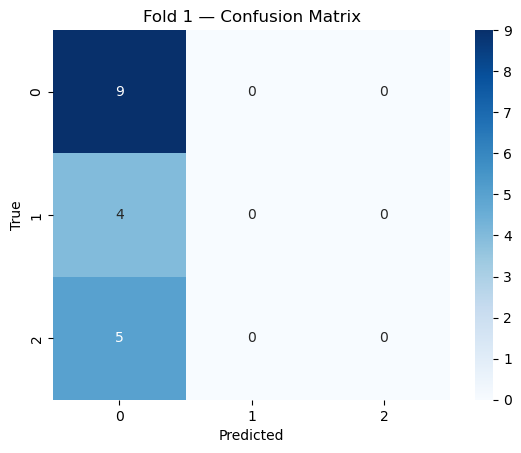


===== Fold 2 =====
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 3.4423 ‚Äî Acc: 29.17%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 3.3072 ‚Äî Acc: 34.72%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 3.4715 ‚Äî Acc: 34.72%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 3.6814 ‚Äî Acc: 40.28%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 3.6802 ‚Äî Acc: 36.11%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 3.2980 ‚Äî Acc: 37.50%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 3.3041 ‚Äî Acc: 38.89%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 3.8968 ‚Äî Acc: 29.17%
üß† Fold 2 ‚Äî Epoch 09 ‚Äî Loss: 3.4184 ‚Äî Acc: 27.78%
üß† Fold 2 ‚Äî Epoch 10 ‚Äî Loss: 3.3653 ‚Äî Acc: 34.72%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



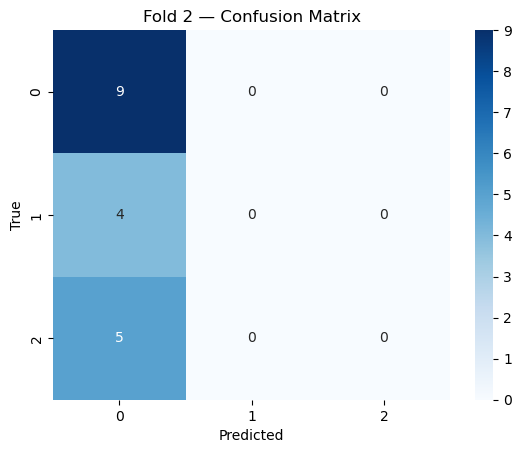


===== Fold 3 =====
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 3.5289 ‚Äî Acc: 25.00%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 3.3839 ‚Äî Acc: 33.33%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 3.6298 ‚Äî Acc: 23.61%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 3.3765 ‚Äî Acc: 36.11%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 3.5457 ‚Äî Acc: 31.94%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 3.3534 ‚Äî Acc: 27.78%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 3.3758 ‚Äî Acc: 45.83%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 3.6914 ‚Äî Acc: 33.33%
üß† Fold 3 ‚Äî Epoch 09 ‚Äî Loss: 3.5404 ‚Äî Acc: 30.56%
üß† Fold 3 ‚Äî Epoch 10 ‚Äî Loss: 3.4595 ‚Äî Acc: 48.61%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



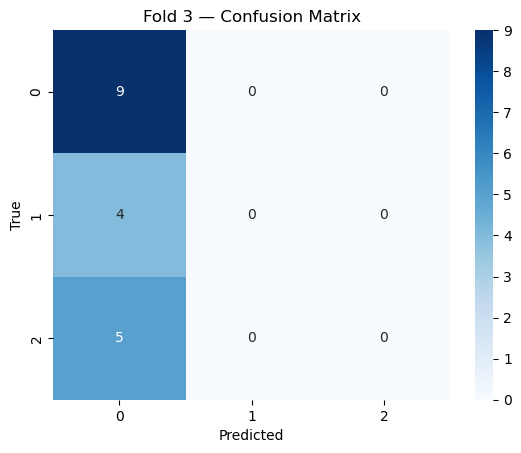


===== Fold 4 =====
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 3.3260 ‚Äî Acc: 34.72%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 3.4624 ‚Äî Acc: 30.56%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 3.5259 ‚Äî Acc: 29.17%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 3.4190 ‚Äî Acc: 37.50%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 3.3834 ‚Äî Acc: 25.00%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 3.3595 ‚Äî Acc: 37.50%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 3.3340 ‚Äî Acc: 33.33%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 3.3839 ‚Äî Acc: 43.06%
üß† Fold 4 ‚Äî Epoch 09 ‚Äî Loss: 3.3964 ‚Äî Acc: 43.06%
üß† Fold 4 ‚Äî Epoch 10 ‚Äî Loss: 3.3057 ‚Äî Acc: 38.89%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



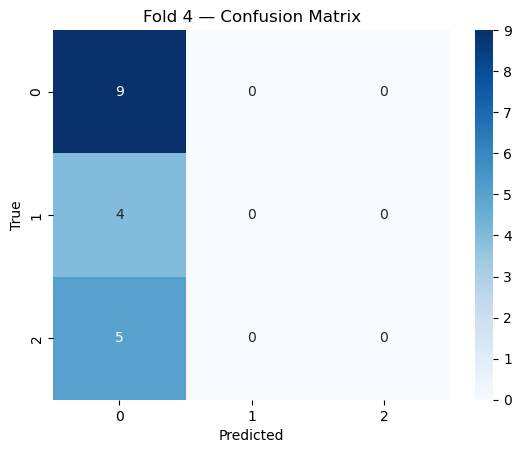


===== Fold 5 =====
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 3.4576 ‚Äî Acc: 31.94%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 3.9218 ‚Äî Acc: 29.17%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 3.4255 ‚Äî Acc: 30.56%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 3.7527 ‚Äî Acc: 41.67%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 3.2602 ‚Äî Acc: 44.44%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 3.5472 ‚Äî Acc: 38.89%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 3.3460 ‚Äî Acc: 40.28%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 3.4142 ‚Äî Acc: 36.11%
üß† Fold 5 ‚Äî Epoch 09 ‚Äî Loss: 3.4707 ‚Äî Acc: 29.17%
üß† Fold 5 ‚Äî Epoch 10 ‚Äî Loss: 3.3866 ‚Äî Acc: 37.50%
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         4

    accuracy                          0.500        18
   macro avg      0.167     0.333     0.222        18
weighted avg      0.250     0.500     0.333        18



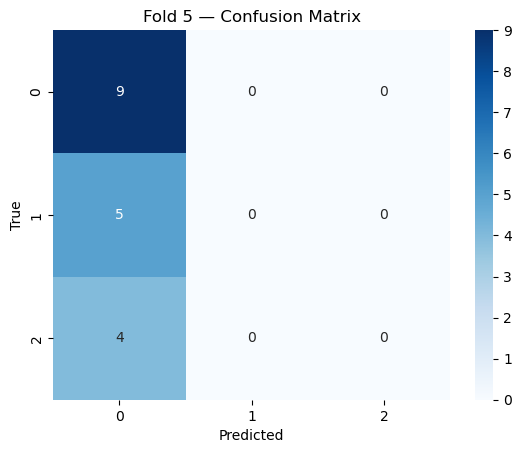

In [8]:
# EEGNet avec pipeline complet et augmentations robustes
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)
print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === Fonctions d'augmentation ===
def add_gaussian_noise(x, std=0.01):
    return x + torch.randn_like(x) * std

def time_shift(x, max_shift=20):
    shift = np.random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(*scale_range)
    return x * scale

def random_warp(x, sigma=0.2):
    x_np = x.squeeze().cpu().numpy()
    length = x_np.shape[-1]
    orig = np.linspace(0, 1, length)
    warp = np.linspace(0, 1, length) + np.random.normal(0, sigma, length)
    warp = np.clip(warp, 0, 1)
    warped = np.stack([np.interp(orig, np.sort(warp), c) for c in x_np])
    return torch.tensor(warped, dtype=x.dtype).reshape_as(x)

def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    indices = np.random.permutation(segs)
    segments = [x[..., i*seg_len:(i+1)*seg_len] for i in indices]
    return torch.cat(segments, dim=-1)

def augment_batch(x):
    augmented = []
    for i in range(x.size(0)):
        xi = x[i].clone()
        if torch.rand(1).item() < 0.5: xi = add_gaussian_noise(xi)
        if torch.rand(1).item() < 0.5: xi = time_shift(xi)
        if torch.rand(1).item() < 0.5: xi = scale_amplitude(xi)
        if torch.rand(1).item() < 0.5: xi = random_warp(xi)
        if torch.rand(1).item() < 0.5: xi = segment_permutation(xi)
        xi = xi[..., :x.shape[-1]]
        xi = nn.functional.pad(xi, (0, x.shape[-1] - xi.shape[-1]))
        augmented.append(xi)
    return torch.stack(augmented)

# === EEGNet modifi√© pour auto-adaptation ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]
        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Cross-validation stratifi√©e ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = augment_batch(xb)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


‚úÖ Labels remapp√©s : {0: 0, 1: 1, 2: 2}
üéØ Nombre de classes d√©tect√©es : 3
üìä Distribution des classes : Counter({0: 45, 2: 24, 1: 21})

===== Fold 1 =====
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 4.6192 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 4.3339 ‚Äî Acc: 40.28%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 4.4225 ‚Äî Acc: 47.22%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 4.3072 ‚Äî Acc: 45.83%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 4.3691 ‚Äî Acc: 44.44%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 4.3411 ‚Äî Acc: 52.78%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 4.4040 ‚Äî Acc: 48.61%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 4.5049 ‚Äî Acc: 43.06%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 4.2862 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 4.3192 ‚Äî Acc: 45.83%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          

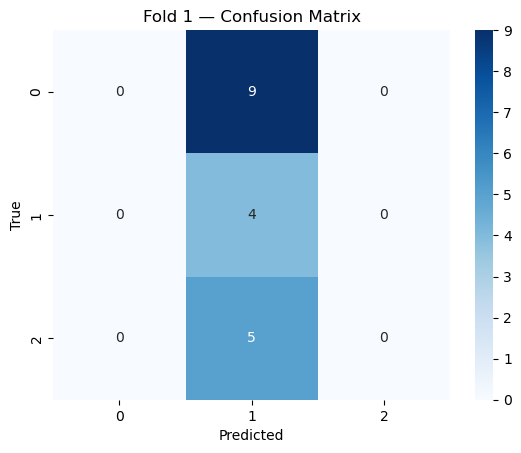


===== Fold 2 =====
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 4.7613 ‚Äî Acc: 36.11%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 4.2055 ‚Äî Acc: 58.33%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 4.3060 ‚Äî Acc: 58.33%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 4.0899 ‚Äî Acc: 62.50%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 4.3499 ‚Äî Acc: 54.17%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 4.4368 ‚Äî Acc: 48.61%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 4.3658 ‚Äî Acc: 50.00%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 4.2920 ‚Äî Acc: 54.17%
üß† Fold 2 ‚Äî Epoch 09 ‚Äî Loss: 4.4111 ‚Äî Acc: 54.17%
üß† Fold 2 ‚Äî Epoch 10 ‚Äî Loss: 4.3067 ‚Äî Acc: 47.22%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.000     0.000     0.000         4
           2      0.278     1.000     0.435         5

    accuracy                          0.278        18
   macro avg      0.093     0.333     0.145        18
weighted avg      0.077     0.278     0.121        18



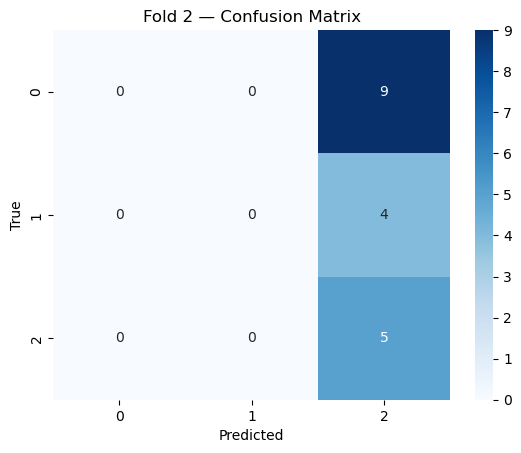


===== Fold 3 =====
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 4.6446 ‚Äî Acc: 47.22%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 4.3940 ‚Äî Acc: 56.94%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 4.4545 ‚Äî Acc: 41.67%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 4.3541 ‚Äî Acc: 48.61%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 4.3068 ‚Äî Acc: 51.39%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 4.3761 ‚Äî Acc: 45.83%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 4.5884 ‚Äî Acc: 52.78%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 4.2798 ‚Äî Acc: 55.56%
üß† Fold 3 ‚Äî Epoch 09 ‚Äî Loss: 4.2937 ‚Äî Acc: 52.78%
üß† Fold 3 ‚Äî Epoch 10 ‚Äî Loss: 4.3701 ‚Äî Acc: 41.67%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          0.222        18
   macro avg      0.074     0.333     0.121        18
weighted avg      0.049     0.222     0.081        18



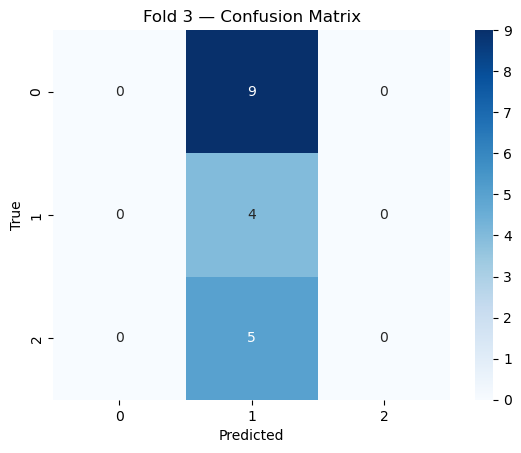


===== Fold 4 =====
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 4.3038 ‚Äî Acc: 70.83%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 4.3769 ‚Äî Acc: 55.56%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 4.2743 ‚Äî Acc: 54.17%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 4.8529 ‚Äî Acc: 45.83%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 4.4582 ‚Äî Acc: 50.00%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 4.2021 ‚Äî Acc: 52.78%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 4.2044 ‚Äî Acc: 50.00%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 4.1890 ‚Äî Acc: 54.17%
üß† Fold 4 ‚Äî Epoch 09 ‚Äî Loss: 4.3016 ‚Äî Acc: 54.17%
üß† Fold 4 ‚Äî Epoch 10 ‚Äî Loss: 4.2203 ‚Äî Acc: 52.78%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          0.222        18
   macro avg      0.074     0.333     0.121        18
weighted avg      0.049     0.222     0.081        18



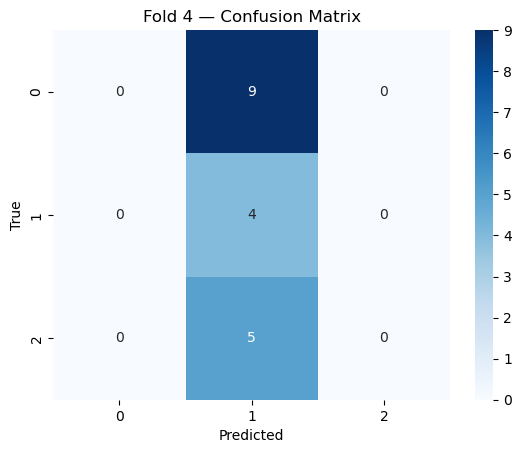


===== Fold 5 =====
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 4.4868 ‚Äî Acc: 55.56%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 4.1506 ‚Äî Acc: 50.00%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 4.1914 ‚Äî Acc: 51.39%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 4.4510 ‚Äî Acc: 48.61%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 4.2659 ‚Äî Acc: 69.44%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 4.2836 ‚Äî Acc: 65.28%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 4.4403 ‚Äî Acc: 44.44%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 4.5790 ‚Äî Acc: 43.06%
üß† Fold 5 ‚Äî Epoch 09 ‚Äî Loss: 4.2447 ‚Äî Acc: 54.17%
üß† Fold 5 ‚Äî Epoch 10 ‚Äî Loss: 4.3065 ‚Äî Acc: 41.67%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.278     1.000     0.435         5
           2      0.000     0.000     0.000         4

    accuracy                          0.278        18
   macro avg      0.093     0.333     0.145        18
weighted avg      0.077     0.278     0.121        18



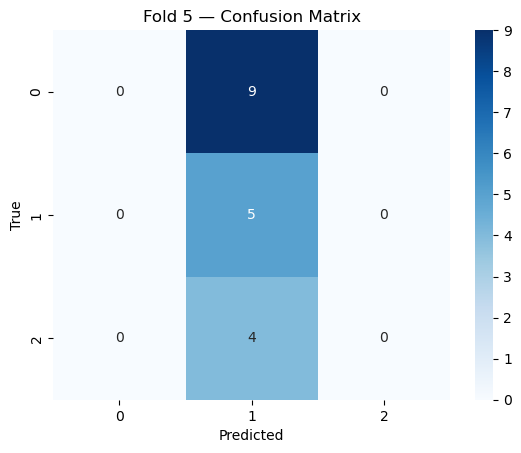

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
# === üì¶ Imports ===
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# === ‚öóÔ∏è Fonctions d‚Äôaugmentation EEG ===
def add_gaussian_noise(x, std=0.05):
    return x + torch.randn_like(x) * std

def time_shift(x, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, scale_range=(0.8, 1.2)):
    factor = np.random.uniform(*scale_range)
    return x * factor

def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    indices = np.random.permutation(segs)
    segments = [x[..., i * seg_len:(i + 1) * seg_len] for i in indices]
    return torch.cat(segments, dim=-1)

def apply_augmentations(x):
    if torch.rand(1).item() < 0.5: x = add_gaussian_noise(x)
    if torch.rand(1).item() < 0.5: x = time_shift(x)
    if torch.rand(1).item() < 0.5: x = scale_amplitude(x)
    if torch.rand(1).item() < 0.5: x = segment_permutation(x)
    return x


# === üìä Oversampling + Augmentation Dataset ===
class BalancedAugmentedDataset(Dataset):
    def __init__(self, X, y):
        self.samples = []
        self.labels = []

        X = X.cpu()
        y = y.cpu()
        self.input_shape = X.shape[-2:]
        self.final_len = self.input_shape[-1]

        # Regroupe par classe
        class_indices = {label.item(): (y == label).nonzero(as_tuple=True)[0] for label in y.unique()}
        max_class_size = max(len(idxs) for idxs in class_indices.values())

        for class_label, idxs in class_indices.items():
            for _ in range(max_class_size):
                sample = X[np.random.choice(idxs)]
                self.samples.append(sample)
                self.labels.append(class_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]
        y = self.labels[idx]
        x = apply_augmentations(x)

        # üîß Forcer la taille finale (padding ou tronquage)
        current_len = x.shape[-1]
        if current_len > self.final_len:
            x = x[..., :self.final_len]
        elif current_len < self.final_len:
            pad_amt = self.final_len - current_len
            x = nn.functional.pad(x, (0, pad_amt))

        return x, y



# üí° Pour l‚Äôint√©grer dans ton code :
# Remplace simplement cette ligne :
# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
# Par :
# train_dataset = BalancedAugmentedDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Tu peux mettre ce bloc complet dans un fichier `augmentation_utils.py` ou bien en haut de ton notebook Python,
# juste apr√®s les `imports` et avant la d√©finition du `EEGNet`. Il est autonome et ne requiert pas de d√©pendance externe
# autre que PyTorch + NumPy.

# === Nettoyage des labels : mapping vers 0...n-1 ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === EEGNet modifi√© pour s‚Äôadapter automatiquement √† l‚Äôentr√©e ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Fonctions d'augmentation de donn√©es ===
def add_gaussian_noise(x, std=0.01):
    return x + torch.randn_like(x) * std

def time_shift(x, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(*scale_range)
    return x * scale

def random_warp(x, sigma=0.2):
    t = np.arange(x.shape[-1])
    warp = np.linspace(0, x.shape[-1] - 1, x.shape[-1]) + np.random.normal(0, sigma, size=x.shape[-1])
    warp = np.clip(warp, 0, x.shape[-1] - 1)

    # s'assurer que x est sur CPU et en numpy avant interpolation
    x_np = x.squeeze().detach().cpu().numpy()
    interp = np.array([np.interp(t, np.sort(warp), ch) for ch in x_np])

    return torch.tensor(interp, dtype=x.dtype).unsqueeze(0)


def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    segments = [x[..., i*seg_len:(i+1)*seg_len] for i in range(segs)]
    if len(segments) < segs: return x
    # Utilise indices au lieu de np.random.permutation pour √©viter la conversion NumPy
    indices = torch.randperm(len(segments))
    permuted = torch.cat([segments[i] for i in indices], dim=-1)
    return permuted


def augment_batch(x):
    augmented = []
    target_len = x.shape[-1]

    for xi in x:
        if torch.rand(1).item() < 0.5: xi = add_gaussian_noise(xi)
        if torch.rand(1).item() < 0.5: xi = time_shift(xi)
        if torch.rand(1).item() < 0.5: xi = scale_amplitude(xi)
        if torch.rand(1).item() < 0.5:
            try:
                xi = random_warp(xi)
            except Exception as e:
                print(f"‚ö†Ô∏è random_warp failed: {e}")
        if torch.rand(1).item() < 0.5:
            try:
                xi = segment_permutation(xi)
            except Exception as e:
                print(f"‚ö†Ô∏è segment_permutation failed: {e}")

        # üîß Normalisation taille
        if xi.shape[-1] > target_len:
            xi = xi[..., :target_len]
        elif xi.shape[-1] < target_len:
            xi = nn.functional.pad(xi, (0, target_len - xi.shape[-1]))

        augmented.append(xi)

    return torch.stack(augmented)



# === Pond√©ration des classes ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# === Cross-validation stratifi√©e ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_dataset = BalancedAugmentedDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = augment_batch(xb)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


‚úÖ Labels remapp√©s : {0: 0, 1: 1, 2: 2}
üéØ Nombre de classes d√©tect√©es : 3
üìä Distribution des classes : Counter({0: 45, 2: 24, 1: 21})

===== Fold 1 =====
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 4.4496 ‚Äî Acc: 45.83%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 4.4886 ‚Äî Acc: 36.11%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 4.3061 ‚Äî Acc: 47.22%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 4.6603 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 4.3447 ‚Äî Acc: 48.61%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 4.2170 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 4.3050 ‚Äî Acc: 45.83%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 4.5893 ‚Äî Acc: 52.78%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 4.1991 ‚Äî Acc: 47.22%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 4.6519 ‚Äî Acc: 41.67%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.000     0.000     0.000         4
           2      0.278     1.000     0.435         5

    accuracy                          

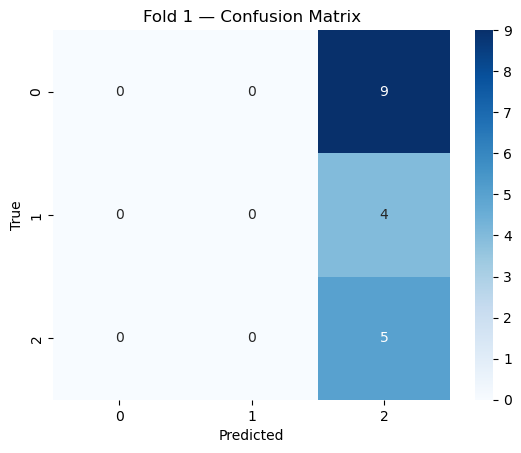


===== Fold 2 =====
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 4.4623 ‚Äî Acc: 56.94%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 4.4993 ‚Äî Acc: 45.83%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 4.6250 ‚Äî Acc: 51.39%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 4.0965 ‚Äî Acc: 48.61%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 4.3917 ‚Äî Acc: 47.22%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 4.4211 ‚Äî Acc: 40.28%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 4.3706 ‚Äî Acc: 50.00%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 4.4507 ‚Äî Acc: 50.00%
üß† Fold 2 ‚Äî Epoch 09 ‚Äî Loss: 4.5345 ‚Äî Acc: 43.06%
üß† Fold 2 ‚Äî Epoch 10 ‚Äî Loss: 4.3516 ‚Äî Acc: 59.72%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          0.222        18
   macro avg      0.074     0.333     0.121        18
weighted avg      0.049     0.222     0.081        18



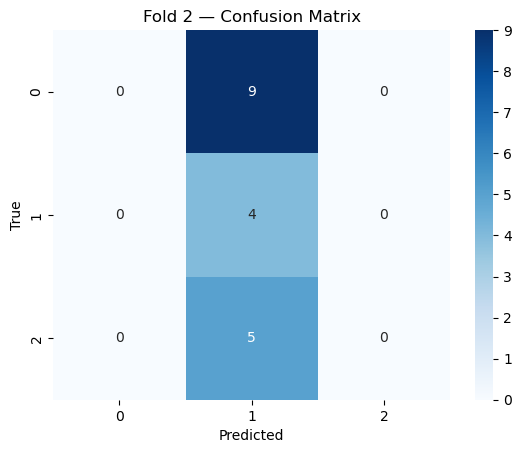


===== Fold 3 =====
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 4.7283 ‚Äî Acc: 52.78%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 4.6041 ‚Äî Acc: 38.89%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 4.5178 ‚Äî Acc: 50.00%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 4.6871 ‚Äî Acc: 40.28%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 4.2862 ‚Äî Acc: 51.39%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 4.3037 ‚Äî Acc: 50.00%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 4.5261 ‚Äî Acc: 41.67%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 4.4982 ‚Äî Acc: 51.39%
üß† Fold 3 ‚Äî Epoch 09 ‚Äî Loss: 4.4971 ‚Äî Acc: 44.44%
üß† Fold 3 ‚Äî Epoch 10 ‚Äî Loss: 4.3582 ‚Äî Acc: 52.78%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          0.222        18
   macro avg      0.074     0.333     0.121        18
weighted avg      0.049     0.222     0.081        18



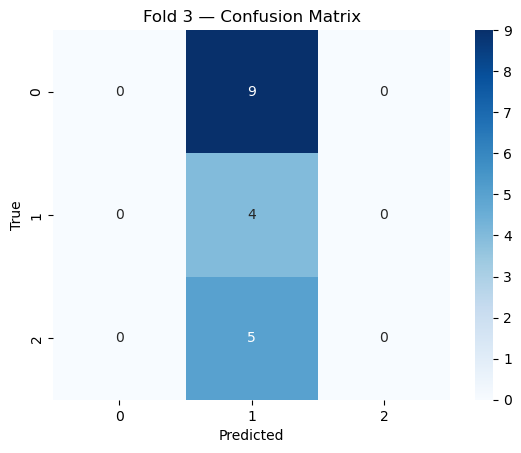


===== Fold 4 =====
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 4.4141 ‚Äî Acc: 61.11%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 4.1146 ‚Äî Acc: 59.72%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 4.6838 ‚Äî Acc: 48.61%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 4.3995 ‚Äî Acc: 50.00%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 4.4758 ‚Äî Acc: 52.78%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 4.3646 ‚Äî Acc: 48.61%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 4.3244 ‚Äî Acc: 55.56%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 4.2771 ‚Äî Acc: 55.56%
üß† Fold 4 ‚Äî Epoch 09 ‚Äî Loss: 4.3965 ‚Äî Acc: 54.17%
üß† Fold 4 ‚Äî Epoch 10 ‚Äî Loss: 4.3283 ‚Äî Acc: 47.22%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.222     1.000     0.364         4
           2      0.000     0.000     0.000         5

    accuracy                          0.222        18
   macro avg      0.074     0.333     0.121        18
weighted avg      0.049     0.222     0.081        18



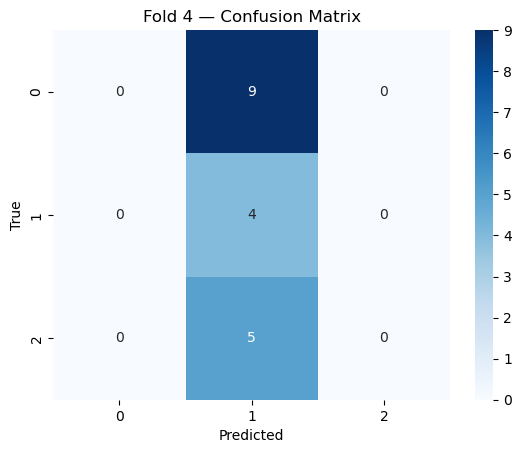


===== Fold 5 =====
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 4.4547 ‚Äî Acc: 52.78%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 4.6167 ‚Äî Acc: 36.11%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 4.2567 ‚Äî Acc: 55.56%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 4.4633 ‚Äî Acc: 54.17%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 4.3690 ‚Äî Acc: 48.61%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 4.4731 ‚Äî Acc: 55.56%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 4.3339 ‚Äî Acc: 43.06%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 4.6660 ‚Äî Acc: 43.06%
üß† Fold 5 ‚Äî Epoch 09 ‚Äî Loss: 4.2207 ‚Äî Acc: 44.44%
üß† Fold 5 ‚Äî Epoch 10 ‚Äî Loss: 4.3960 ‚Äî Acc: 50.00%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           1      0.278     1.000     0.435         5
           2      0.000     0.000     0.000         4

    accuracy                          0.278        18
   macro avg      0.093     0.333     0.145        18
weighted avg      0.077     0.278     0.121        18



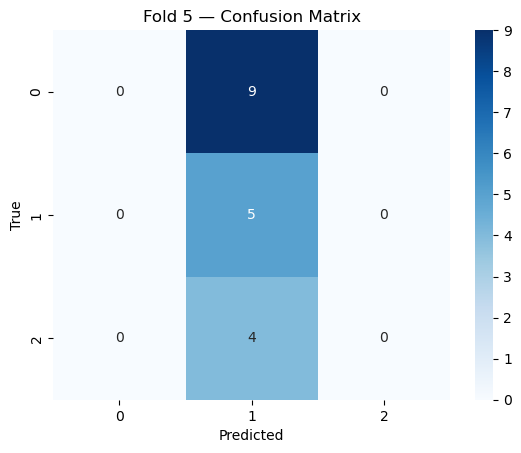

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# === Nettoyage des labels ===
unique_labels = torch.unique(y)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y = torch.tensor([label_map[label.item()] for label in y])
n_classes = len(unique_labels)

print(f"‚úÖ Labels remapp√©s : {label_map}")
print(f"üéØ Nombre de classes d√©tect√©es : {n_classes}")
print(f"üìä Distribution des classes : {Counter(y.tolist())}")

# === EEGNet ===
class EEGNet(nn.Module):
    def __init__(self, n_classes, input_shape):
        super().__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding="same", bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_shape[0], 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 15), padding="same", bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape).float()
            dummy_out = self.separableConv(self.depthwiseConv(self.firstConv(dummy_input)))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]
        self.classify = nn.Linear(self.flatten_dim, n_classes)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        elif x.ndim == 5:
            x = x.squeeze(1)
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# === Fonctions d'augmentation ===
def add_gaussian_noise(x, std=0.01):
    return x + torch.randn_like(x) * std

def time_shift(x, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=-1)

def scale_amplitude(x, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(*scale_range)
    return x * scale

def random_warp(x, sigma=0.2):
    try:
        x_np = x.squeeze().cpu().numpy()
        t = np.arange(x_np.shape[-1])
        warp = np.linspace(0, x_np.shape[-1] - 1, x_np.shape[-1]) + np.random.normal(0, sigma, size=x_np.shape[-1])
        warp = np.clip(warp, 0, x_np.shape[-1] - 1)
        warped = np.array([np.interp(t, np.sort(warp), ch) for ch in x_np])
        return torch.tensor(warped, dtype=x.dtype).unsqueeze(0)
    except Exception as e:
        print(f"‚ö†Ô∏è random_warp failed: {e}")
        return x

def segment_permutation(x, segs=4):
    seg_len = x.shape[-1] // segs
    segments = [x[..., i*seg_len:(i+1)*seg_len] for i in range(segs)]
    if len(segments) < segs: return x
    indices = torch.randperm(len(segments))
    permuted = torch.cat([segments[i] for i in indices], dim=-1)
    return permuted

def augment_batch(x):
    augmented = []
    for xi in x:
        if torch.rand(1).item() < 0.5: xi = add_gaussian_noise(xi)
        if torch.rand(1).item() < 0.5: xi = time_shift(xi)
        if torch.rand(1).item() < 0.5: xi = scale_amplitude(xi)
        if torch.rand(1).item() < 0.5: xi = random_warp(xi)
        if torch.rand(1).item() < 0.5: xi = segment_permutation(xi)
        xi = xi[..., :x.shape[-1]]
        xi = nn.functional.pad(xi, (0, x.shape[-1] - xi.shape[-1])) if xi.shape[-1] < x.shape[-1] else xi
        augmented.append(xi)
    return torch.stack(augmented)

# === üéØ Fonction robuste d'augmentation avec padding/troncature ===
def apply_augmentations(x, target_length):
    if torch.rand(1).item() < 0.5: x = add_gaussian_noise(x)
    if torch.rand(1).item() < 0.5: x = time_shift(x)
    if torch.rand(1).item() < 0.5: x = scale_amplitude(x)
    if torch.rand(1).item() < 0.5:
        try:
            x = random_warp(x)
        except Exception as e:
            print(f"‚ö†Ô∏è random_warp failed: {e}")
    if torch.rand(1).item() < 0.5:
        try:
            x = segment_permutation(x)
        except Exception as e:
            print(f"‚ö†Ô∏è segment_permutation failed: {e}")
    # ü©π Correction de la taille finale
    current_len = x.shape[-1]
    if current_len < target_length:
        x = nn.functional.pad(x, (0, target_length - current_len))
    elif current_len > target_length:
        x = x[..., :target_length]
    return x

# === üìä Oversampling + Augmentation Dataset (corrig√©) ===
class BalancedAugmentedDataset(Dataset):
    def __init__(self, X, y):
        self.samples = []
        self.labels = []

        X = X.cpu()
        y = y.cpu()
        self.input_shape = X.shape[-2:]  # (n_channels, n_times)
        self.target_len = self.input_shape[-1]

        # Regroupe les indices par classe
        class_indices = {label.item(): (y == label).nonzero(as_tuple=True)[0] for label in y.unique()}
        max_class_size = max(len(idxs) for idxs in class_indices.values())

        for class_label, idxs in class_indices.items():
            for _ in range(max_class_size):
                sample = X[np.random.choice(idxs)]
                self.samples.append(sample)
                self.labels.append(class_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]
        y = self.labels[idx]
        x = apply_augmentations(x, self.target_len)
        return x, y



# === Cross-validation et apprentissage ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = EEGNet(n_classes=n_classes, input_shape=X.shape[-2:]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_dataset = BalancedAugmentedDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = augment_batch(xb)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
        acc = correct / len(y_train)
        print(f"üß† Fold {fold+1} ‚Äî Epoch {epoch:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(DEVICE)).argmax(dim=1).cpu()
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Fold {fold+1} ‚Äî Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
